<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-practicres/blob/main/YoloV2Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.8.0


In [35]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

--2022-04-11 16:51:29--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar.1’

VOCtrainval_11-May- 100%[===================>]   1.86G  11.6MB/s    in 2m 50s  

2022-04-11 16:54:21 (11.2 MB/s) - ‘VOCtrainval_11-May-2012.tar.1’ saved [1999639040/1999639040]



In [37]:
! tar xvf VOCtrainval_11-May-2012.tar

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC

##Parse annotations from the XML files and store it in an array

In [38]:
import os
import xml.etree.ElementTree as ET


def parse_annotation(ann_dir, img_dir, labels=[]):
    all_img = []
    seen_labels = {}

    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue

        img = {'object': []}

        tree = ET.parse(ann_dir + ann)
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                # make sure that image exists
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}

                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text
                        if len(labels) > 0  and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_img += [img]

    return all_img, seen_labels

In [39]:
import numpy as np
# Parse annotation
train_image_folder = "VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "VOCdevkit/VOC2012/Annotations/"

ANCHORS = np.array([
    1.07709888,  1.78171903,  # anchor box 1, width , height
    2.71054693,  5.12469308,  # anchor box 2, width,  height
    10.47181473, 10.09646365,  # anchor box 3, width,  height
    5.48531347,  8.11011331    # anchor box 4, width, height
])

LABELS = [
    'aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
    'bus',        'car',      'cat',  'chair',     'cow',
    'diningtable','dog',    'horse',  'motorbike', 'person',
    'pottedplant','sheep',  'sofa',   'train',   'tvmonitor'
]

train_images, seen_train_labels = parse_annotation(
    train_annot_folder, train_image_folder, labels=LABELS)

print("train number: {}".format(len(train_images)))

train number: 17125


##Define a class to process an image

In [40]:
import copy
import cv2


class ImageReader(object):
    def __init__(self, image_h, image_w, norm=None):
        self.IMAGE_H = image_h
        self.IMAGE_W = image_w
        self.norm = norm

    def encode_core(self, image, reorder_rgb=True):
        image = cv2.resize(image, (self.IMAGE_H, self.IMAGE_W))

        if reorder_rgb:
            image = image[:, :, ::-1]
        
        if self.norm:
            image = self.norm(image)
        return image

    def fit(self, train_instance):
        if not isinstance(train_instance, dict):
            train_instance = {'filename': train_instance}
        
        img_name = train_instance['filename']
        image = cv2.imread(img_name)
        if image is None: print("Cannot find", img_name)
        h, w, c = image.shape

        image = self.encode_core(image, reorder_rgb=True)

        if "object" in train_instance.keys():

            all_objs = copy.deepcopy(train_instance['object'])
            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
                    obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
                    obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
        else:
            return image
        return image, all_objs

###Sample usage of class "ImageReader"


******************************
Input
    object: [{'name': 'person', 'xmin': 174, 'ymin': 101, 'xmax': 349, 'ymax': 351}]
    filename: VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg
    width: 486
    height: 500
******************************
Output
        [{'name': 'person', 'xmin': 148, 'ymin': 84, 'xmax': 298, 'ymax': 292}]


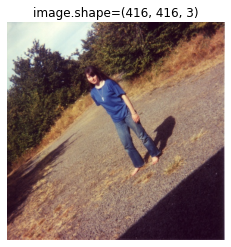

In [41]:
def normalize(image): 
    return image / 255.

print("*"*30)
print("Input")

sample = train_images[0]
for k, v in sample.items():
    print("    {}: {}".format(k, v))
print("*"*30)
print("Output")
inputEncoder = ImageReader(image_h=416, image_w=416, norm=normalize)
image, all_objects = inputEncoder.fit(sample)
print("        {}".format(all_objects))
plt.imshow(image)
plt.title("image.shape={}".format(image.shape))
plt.axis('off')
plt.show()

###Define Best Anchor box finder

In [42]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, confidence=None, 
                 classes=None):
        self.xmin, self.ymin = xmin, ymin
        self.xmax, self.ymax = xmax, ymax

        self.confidence = confidence
        self.set_class(classes)

    def set_class(self, classes):
        self.classes = classes
        self.label = np.argmax(self.classes)

    def get_label(self):
        return self.label

    def get_score(self):
        return self.classes[self.label]


class BestAnchorBoxFinder(object):
    def __init__(self, ANCHORS):
        """
        ANCHORS:  a np.array of even number length e.g.

        _ANCHORS = [
            4, 2, ##width=4, height=2, flat large anchor box
            2, 4, ##width=2, height=4, tall large box
            1, 1, ##width=1, height=1, small anchor box
        ]
        """
        self.anchors = [BoundBox(0, 0, ANCHORS[2*i], ANCHORS[2*i+1]) 
                        for i in range(int(len(ANCHORS) // 2))]
        
    def _interval_overlap(self, interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        return max(min(x2, x4) - max(x1, x3), 0)
    
    def intersect_over_union(self, box1, box2):
        intersect_w = self._interval_overlap([box1.xmin, box1.xmax], 
                                             [box2.xmin, box2.xmax])
        intersesect_h = self._interval_overlap([box1.ymin, box1.ymax],
                                               [box2.ymin, box2.ymax])
        intersect_area = intersect_w * intersesect_h

        w1, h1 = box1.xmax - box1.xmin, box1.ymax - box1.ymin
        w2, h2 = box2.xmax - box2.xmin, box2.ymax - box2.ymin

        union_area = w1 * h1 + w2 * h2 - intersect_area + 1e-6
        return float(intersect_area) / union_area
    
    def find(self, center_w, center_h):
        # Find anchor that best predicts this box
        best_anchor = -1
        max_iou = -1

        shifted_box = BoundBox(0, 0, center_w, center_h)
        # For given object find the best box
        for i in range(len(self.anchors)):
            anchor = self.anchors[i]
            iou = self.intersect_over_union(shifted_box, anchor)
            if max_iou < iou:
                best_anchor = i
                max_iou = iou
        
        return best_anchor, max_iou


###Sample usage of BestAnchorBoxFinder class

In [43]:
_ANCHORS01 = np.array([0.08285376, 0.13705531,
                       0.20850361, 0.39420716,
                       0.80552421, 0.77665105,
                       0.42194719, 0.62385487])

print(",,"*40)
print("The three example anchor boxes:")
count = 0
for i in range(0, len(_ANCHORS01), 2):
    print("anchor box index={}, w={}, h={}".format(count, _ANCHORS01[i], _ANCHORS01[i+1]))
    count += 1

print(",,"*40)
print("Allocate bounding box of various width and height into the three anchor boxes:")
babf = BestAnchorBoxFinder(_ANCHORS01)
for w in range(1, 9, 2):
    w /= 10.
    for h in range(1, 9, 2):
        h /= 10.
        best_anchor, max_iou = babf.find(w, h)
        print("Bounding box (w = {}, h = {}) --> best  anchor box = {}, iou = {:3.2f}".format(
            w, h, best_anchor, max_iou
        ))

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
The three example anchor boxes:
anchor box index=0, w=0.08285376, h=0.13705531
anchor box index=1, w=0.20850361, h=0.39420716
anchor box index=2, w=0.80552421, h=0.77665105
anchor box index=3, w=0.42194719, h=0.62385487
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allocate bounding box of various width and height into the three anchor boxes:
Bounding box (w = 0.1, h = 0.1) --> best  anchor box = 0, iou = 0.63
Bounding box (w = 0.1, h = 0.3) --> best  anchor box = 0, iou = 0.38
Bounding box (w = 0.1, h = 0.5) --> best  anchor box = 1, iou = 0.42
Bounding box (w = 0.1, h = 0.7) --> best  anchor box = 1, iou = 0.35
Bounding box (w = 0.3, h = 0.1) --> best  anchor box = 0, iou = 0.25
Bounding box (w = 0.3, h = 0.3) --> best  anchor box = 1, iou = 0.57
Bounding box (w = 0.3, h = 0.5) --> best  anchor box = 3, iou = 0.57
Bounding box (w = 0.3, h = 0.7) --> best  anchor box = 3

In [44]:
def rescale_centerxy(obj, config):
    """
    obj:    a dictionary containing xmin, xmax, ymin, ymax
    config: a dictionary containing IMAGE_W, GIRD_W, IMAGE_H, GRID_H
    """
    center_x = 0.5 * (obj['xmin'] + obj['xmax'])
    center_x = center_x / (float(config['IMAGE_W']) / config['GRID_W'])
    center_y = 0.5 * (obj['ymin'] + obj['ymax'])
    center_y = center_y / (float(config['IMAGE_H']) / config['GRID_H'])
    return center_x, center_y

def rescale_centerwh(obj, config):
    """
    obj:    a dictionary containing xmin, xmax, ymin, ymax
    config: a dictionary containing IMAGE_W, GIRD_W, IMAGE_H, GRID_H
    """
    # unit grid cell
    center_w = (obj['xmax'] - obj['xmin']) / (float(config['IMAGE_W']) / config['GRID_W'])
    center_h = (obj['ymax'] - obj['ymin']) / (float(config['IMAGE_H']) / config['GRID_H'])

    return center_w, center_h

In [45]:
obj    = {'xmin': 150, 'ymin': 84, 'xmax': 300, 'ymax': 294}
config = {"IMAGE_W":416,"IMAGE_H":416,"GRID_W":13,"GRID_H":13}

center_x, center_y = rescale_centerxy(obj, config)
center_w, center_h = rescale_centerwh(obj, config)

print("cebter_x abd cebter_w should range between 0 and {}".format(config["GRID_W"]))
print("cebter_y abd cebter_h should range between 0 and {}".format(config["GRID_H"]))

print("center_x = {:06.3f} range between 0 and {}".format(center_x, config["GRID_W"]))
print("center_y = {:06.3f} range between 0 and {}".format(center_y, config["GRID_H"]))
print("center_w = {:06.3f} range between 0 and {}".format(center_w, config["GRID_W"]))
print("center_h = {:06.3f} range between 0 and {}".format(center_h, config["GRID_H"]))

cebter_x abd cebter_w should range between 0 and 13
cebter_y abd cebter_h should range between 0 and 13
center_x = 07.031 range between 0 and 13
center_y = 05.906 range between 0 and 13
center_w = 04.688 range between 0 and 13
center_h = 06.562 range between 0 and 13


##Define a custom Batch generator

In [46]:
from tensorflow.keras.utils import Sequence

class SimpleBatchGenerator(Sequence):
    def __init__(self, images, config, norm=None, shuffle=True):
        """
        Config:     a dict containing hyper parameters for training e.g.
            {
                'IMAGE_W'     :416,
                'IMAGE_H'     :426, 
                'GRID_W'      :13,
                'GRID_H'      :13,
                'LABELS'      :[
                    'aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                    'bus',        'car',      'cat',  'chair',     'cow',
                    'diningtable','dog',    'horse',  'motorbike', 'person',
                    'pottedplant','sheep',  'sofa',   'train',   'tvmonitor'
                ], 
                'ANCHORS'       : array([
                    1.07709888,   1.78171903,  
                    2.71054693,   5.12469308, 
                    10.47181473, 10.09646365,  
                    5.48531347,   8.11011331
                ]), 
                BATCH_SIZE      : 16,
                TRUE_BOX_BUFFER: 50
            }
            """

        self.config = config
        self.config['BOX'] = int(len(self.config['ANCHORS']) / 2)
        self.config['CLASS'] = len(self.config['LABELS'])
        self.images = images
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(self.config['ANCHORS'])
        self.image_reader = ImageReader(self.config['IMAGE_H'], 
                                        self.config['IMAGE_W'], norm=norm)
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.images)

    def __len__(self):
        return int(np.ceil(float(len(self.images)) / self.config['BATCH_SIZE']))
    
    def __getitem__(self, idx):
        '''
        ===input===

        idx : non-negative integer value

        ==output==

        x_batch: The numpy array of shape (BATCH_SIZE, IMAGE_H, IMAGE_W, N CHANNELS)

        y_btach: The numpy array of shape (BATCH_SIZE, GRID_H, GRID_W, BOX, 4+1+N CHANNELS)

        BOX = The number of Anchor box

        b_batch: The numpy array of shape (batch_size, 1, 1, 1, TRUE_BOX_BUFFER, 4)
        '''
        l_bound = idx * self.config['BATCH_SIZE']
        r_bound = (idx + 1) * self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0

        # prepare empty storage space
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], 
                            self.config['IMAGE_W'], 3))
        b_batch = np.zeros((r_bound - l_bound, 1, 1, 1, 
                            self.config['TRUE_BOX_BUFFER'], 4))
        # desired network output
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'], 
                            self.config['GRID_W'], self.config['BOX'], 
                            4+1+len(self.config['LABELS'])))
        
        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.image_reader.fit(train_instance)
            # constructs output from object's x, y, w, h
            true_box_index = 0

            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x, center_y = rescale_centerxy(obj, self.config)

                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_idx = self.config['LABELS'].index(obj['name'])
                        center_w, center_h = rescale_centerwh(obj, self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor, max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)

                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box 
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4] = 1.     # ground truth confidence is 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_idx] = 1 # class probability of the object

                        # assign true_box_index to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
            
            x_batch[instance_count] = img
            instance_count += 1
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle:
            return np.random.shuffle(self.images)

In [47]:
GRID_H,  GRID_W  = 13 , 13
ANCHORS          = _ANCHORS01
ANCHORS[::2]     = ANCHORS[::2]*GRID_W  
ANCHORS[1::2]    = ANCHORS[1::2]*GRID_H  
ANCHORS

array([ 1.07709888,  1.78171903,  2.71054693,  5.12469308, 10.47181473,
       10.09646365,  5.48531347,  8.11011331])

In [48]:
IMAGE_H, IMAGE_W = 416, 416
BATCH_SIZE       = 16
TRUE_BOX_BUFFER  = 50
BOX = int(len(ANCHORS)/2)
CLASS = len(LABELS)

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}

train_batch_generator = SimpleBatchGenerator(train_images, generator_config, 
                                             norm=normalize, shuffle=True)

[x_batch, b_batch], y_batch = train_batch_generator.__getitem__(idx=1)

print("x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = {}".format(x_batch.shape))
print("y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {}".format(y_batch.shape))
print("b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = {}".format(b_batch.shape))


x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = (16, 416, 416, 3)
y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = (16, 13, 13, 4, 25)
b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = (16, 1, 1, 1, 50, 4)


In [49]:
iframe = 1

def check_object_in_grid_anchor_pair(irow):
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow, igrid_h, igrid_w, ianchor, :]
                C = vec[4]   # ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    assert len(class_nm) == 1
                    print("igrid_h={:02.0f}, igrid_w={:02.0f}, iAnchor={:02.0f}, {}".format(
                        igrid_h, igrid_w, ianchor, class_nm[0]
                    ))

check_object_in_grid_anchor_pair(iframe)

igrid_h=06, igrid_w=01, iAnchor=01, boat
igrid_h=06, igrid_w=04, iAnchor=01, boat
igrid_h=06, igrid_w=08, iAnchor=01, boat


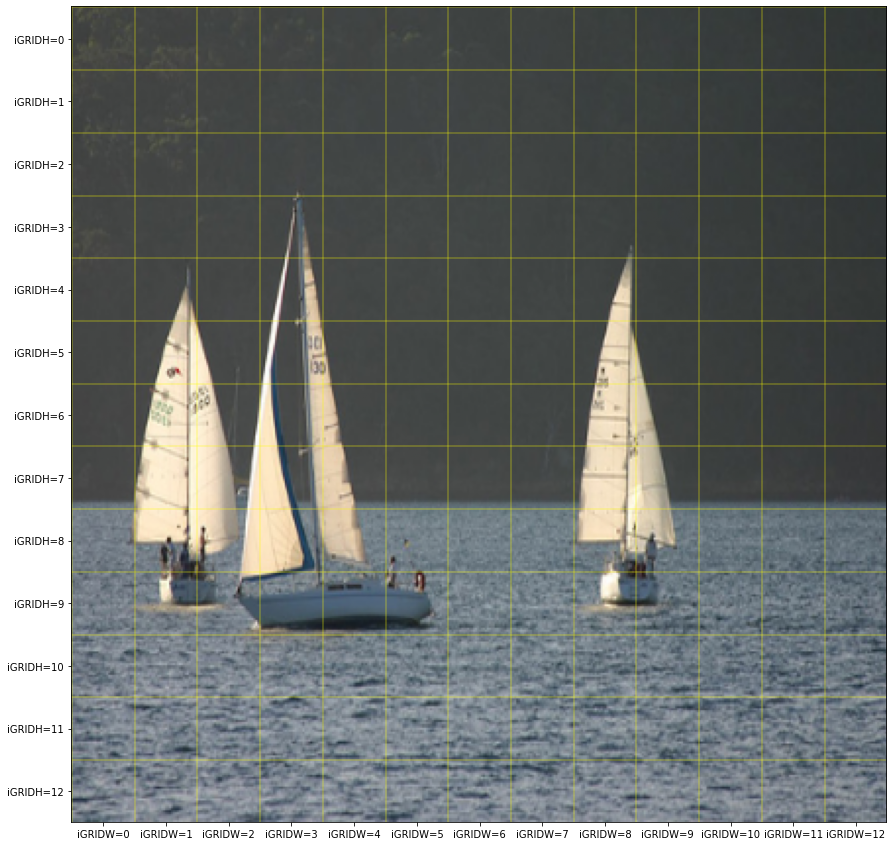

In [52]:
def plot_image_with_grid_cell_partition(irow):
    img = x_batch[irow]
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    # plot grid on image
    for wh in ["W", "H"]:
        GRID_ = generator_config["GRID_" + wh]  # 13
        IMAGE_ = generator_config["IMAGE_" + wh]    # 416
        if wh == "W":
            pltax = plt.axvline
            plttick = plt.xticks
        else:
            pltax = plt.axhline
            plttick  = plt.yticks
        
        for count in range(GRID_):
            pltax(IMAGE_*count/GRID_, color='yellow', alpha=0.3)

        plttick([IMAGE_*(i+0.5)/GRID_ for i in range(GRID_)], 
                ["iGRID{}={}".format(wh, i) for i in range(GRID_)])

plot_image_with_grid_cell_partition(iframe)